# IT3103 Assignment 1

### Importing the necessary libraries

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os
import numpy as np

### Importing the dataset
Imports the datasets to be used when training the model

In [2]:
# Get the file from the link
dataset_URL = 'https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/it3103/datasets/fruits.zip'

# Extract the file into a folder
path_to_zip = tf.keras.utils.get_file('fruits.zip', origin=dataset_URL, extract=True, cache_dir='.')

# Set the path to look for the files
dataset_dir = os.path.join(os.path.dirname(path_to_zip), "fruits_extracted/fruits")
dataset_dir_valid = os.path.join(os.path.dirname(path_to_zip), "fruits_extracted/fruits")

### Extracting datasets 

In [3]:
# Training Directory
trainingDirectory = os.path.join(dataset_dir, "train")

# Validation Directory
validationDirectory = os.path.join(dataset_dir_valid, "valid")

### Creating the Model

In [4]:
def make_model():
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(128,128, 3)))
    model.add(keras.layers.Rescaling(1./255))

    # Data Augmentation
    model.add(keras.layers.RandomFlip("horizontals_and_vertical"))
    model.add(keras.layers.RandomRotation(0.3))
    model.add(keras.layers.RandomZoom(0.3))
    
    model.add(keras.layers.Conv2D(32, (3, 3), activation="relu"))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(6, activation="softmax"))

    return model

model = make_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 128, 128, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                      

### Adding Optimizer and Loss Function

In [5]:
# Sparse Categorical Crossentropy is used when truth labels are integer coded and have multiple classes
# Categorical Crossentropy is used when it is one hot coded
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

### Data Preprocessing

In [6]:
imgHeight, imgWidth = 128, 128
batchSize = 32

# Resizing all images into the smae size
imageSize = (imgHeight, imgWidth)

trainingDataset = keras.preprocessing.image_dataset_from_directory(
    trainingDirectory,
    seed=1,
    image_size=imageSize,
    batch_size=batchSize,
    label_mode="int"
)

validationDataset = keras.preprocessing.image_dataset_from_directory(
    validationDirectory,
    seed=1,
    image_size=imageSize,
    batch_size=batchSize,
    label_mode="int"
)

for images, labels in trainingDataset.take(1):
    print("Images Shape: ", images.shape)
    print("Labels Shape: ", labels.shape)
    print(tf.squeeze(labels))

# print out the indices to find out the class
print(trainingDataset.class_names)
print(validationDataset.class_names)

Found 1182 files belonging to 6 classes.
Found 329 files belonging to 6 classes.
Images Shape:  (32, 128, 128, 3)
Labels Shape:  (32,)
tf.Tensor([2 3 0 3 4 3 4 4 1 2 4 0 4 1 2 1 3 5 1 3 2 5 1 3 4 3 3 0 3 0 0 0], shape=(32,), dtype=int32)
['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


### Training the Model

In [7]:
def create_tb_callback():
    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():
        import time
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()
    tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)

    return tb_callback

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="bestcheckpoint.weights.h5",
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

model.fit(
    trainingDataset,
    epochs=50,
    validation_data=validationDataset,
    callbacks=[create_tb_callback(), model_checkpoint_callback]
)

Epoch 1/50
37/37 [==============================] - 8s 115ms/step - loss: 1.7355 - accuracy: 0.2741 - val_loss: 1.5836 - val_accuracy: 0.3860
Epoch 2/50
37/37 [==============================] - 4s 101ms/step - loss: 1.4909 - accuracy: 0.4010 - val_loss: 1.2541 - val_accuracy: 0.4833
Epoch 3/50
37/37 [==============================] - 4s 113ms/step - loss: 1.2966 - accuracy: 0.4492 - val_loss: 1.1197 - val_accuracy: 0.5927
Epoch 4/50
37/37 [==============================] - 4s 110ms/step - loss: 1.1521 - accuracy: 0.5212 - val_loss: 1.0032 - val_accuracy: 0.6079
Epoch 5/50
37/37 [==============================] - 4s 118ms/step - loss: 1.0755 - accuracy: 0.5685 - val_loss: 1.0543 - val_accuracy: 0.6109
Epoch 6/50
37/37 [==============================] - 4s 115ms/step - loss: 0.9830 - accuracy: 0.6159 - val_loss: 0.8377 - val_accuracy: 0.6869
Epoch 7/50
37/37 [==============================] - 4s 113ms/step - loss: 0.8897 - accuracy: 0.6557 - val_loss: 0.7964 - val_accuracy: 0.6869
Epoch 

In [8]:
keras.models.save_model(model, filepath="cur_model.keras")

### Testing the Model

freshapples


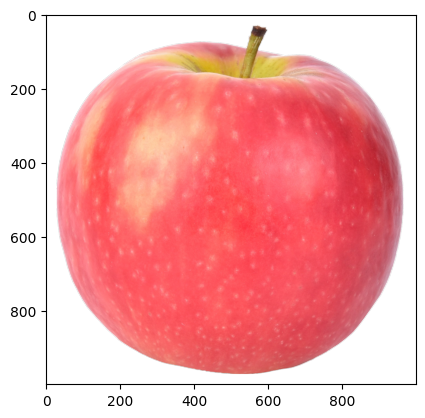

In [12]:
from enum import Enum
import matplotlib.image as mpimg

filename = "TestImages/apple.jpg"

img = mpimg.imread(filename)
imgplot = plt.imshow(img)


test_image = keras.preprocessing.image.load_img(
    filename, target_size=(128, 128)
)

# Converts the image to numpy array
img_array = keras.preprocessing.image.img_to_array(test_image)

img_array = tf.expand_dims(img_array, 0)

# Loading the model  to do the inference
model = tf.keras.models.load_model("cur_model.keras")
predicted_label = model(img_array)

class FruitType(Enum):
    freshapples = 0
    freshbanana = 1
    freshoranges = 2
    rottenapples = 3
    rottenbanana = 4
    rottenoranges = 5

print(FruitType(np.argmax(predicted_label)).name)

In [10]:
validationDataset.class_names

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']